# Plotting Jazayeri & Shadlen (2010) data

Code to reproduce the plot in their paper: https://www.nature.com/articles/nn.2590.pdf

#### Model is built after this section

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [155]:
dat = pd.read_csv("dataJS.csv")
dat.head()

Subj  Cond  line  Trial      Ts      Tp  MaxTrial   Main
0     1     1     1      1  847.01  863.26      1489  False
1     1     1     2      2  705.84  683.01      1489  False
2     1     1     3      3  670.55  711.81      1489  False
3     1     1     4      4  847.01  829.67      1489  False
4     1     1     5      5  705.84  695.06      1489  False

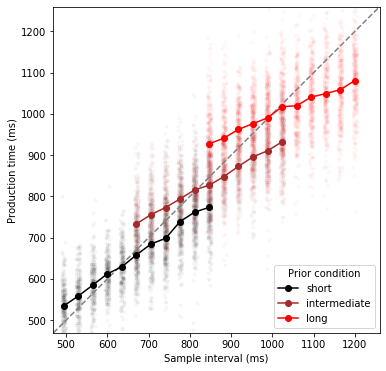

In [156]:
# Remove training trials
dat = dat[dat['Main'] == True]

# Calculate mean Tp by condition
mean_tp_by_subj = dat.groupby(['Subj', 'Cond', 'Ts'])['Tp'].mean().reset_index()
mean_tp = mean_tp_by_subj.groupby(['Cond', 'Ts'])['Tp'].mean().reset_index()

yrange = np.multiply((min(mean_tp['Ts']), max(mean_tp['Ts'])), [0.95, 1.05])

# Subset data for plotting

cond1 = mean_tp.loc[mean_tp['Cond'] == 1]
cond2 = mean_tp.loc[mean_tp['Cond'] == 2]
cond3 = mean_tp.loc[mean_tp['Cond'] == 3]

# Add jitter noise
jitter = dat.copy()
jitter['Ts'] = jitter['Ts'] + np.random.uniform(-5, 5, len(dat))
cond1_jitter = jitter.loc[jitter['Cond'] == 1]
cond2_jitter = jitter.loc[jitter['Cond'] == 2]
cond3_jitter = jitter.loc[jitter['Cond'] == 3]

# Make plot
f, ax = plt.subplots(figsize = (6,6))

ax.set(xlim = yrange, ylim = yrange)
f.gca().set_aspect('equal', adjustable = 'box')

ax.set_xlabel('Sample interval (ms)')
ax.set_ylabel('Production time (ms)')

ax.plot(yrange, yrange, linestyle = '--', color ='gray')

ax.scatter(cond1_jitter['Ts'], cond1_jitter['Tp'], marker = '.', color = 'black', alpha = 0.025, label = None)
ax.scatter(cond2_jitter['Ts'], cond2_jitter['Tp'], marker = '.', color = 'brown', alpha = 0.025, label = None)
ax.scatter(cond3_jitter['Ts'], cond3_jitter['Tp'], marker = '.', color = 'red', alpha = 0.025, label = None)

ax.plot(cond1['Ts'], cond1['Tp'], color = 'black', marker = 'o', label = "short")
ax.plot(cond2['Ts'], cond2['Tp'], color = 'brown', marker = 'o', label = "intermediate")
ax.plot(cond3['Ts'], cond3['Tp'], color = 'red', marker = 'o', label = "long")

ax.legend(title = 'Prior condition', loc = 4)

# Modelling the Experiment

In [16]:
#Importing necessary packages
from model import Model
from dmchunk import Chunk
import math
import random

In [17]:
# Declaring the parameters of the experiment.
subjects = 6
conditions = 3
MaxTrial = 1500


# This is the uniform prior sample distribution we will be using.
timings = np.array([494.09,  529.38,  564.67,  599.96,  635.26,  670.55,  705.84,
        741.13,  776.42,  811.72,  847.01,  882.3 ,  917.59,  952.88,
        988.18, 1023.5 , 1058.8 , 1094.1 , 1129.3 , 1164.6 , 1199.9])

# The short , intermediate , long overlapping samples
short = timings[0:11]
intermediate = timings[5:16]
long = timings[10:21]
condition_timings = [short,intermediate,long]

In [18]:
#Short sample
short

array([494.09, 529.38, 564.67, 599.96, 635.26, 670.55, 705.84, 741.13,
       776.42, 811.72, 847.01])

In [19]:
#Intermediate sample
intermediate

array([ 670.55,  705.84,  741.13,  776.42,  811.72,  847.01,  882.3 ,
        917.59,  952.88,  988.18, 1023.5 ])

In [20]:
#Long sample
long

array([ 847.01,  882.3 ,  917.59,  952.88,  988.18, 1023.5 , 1058.8 ,
       1094.1 , 1129.3 , 1164.6 , 1199.9 ])

In [21]:
# This is where we store our modelled data, we use this dataframe to plot the above graph
modelled_data = pd.DataFrame(columns = ['Subj','Cond','Trial','Ts','Tp','Main'])

In [22]:
# The timing functions

def noise(s):
    rand = random.uniform(0.001,0.999)
    return s * math.log((1 - rand)/rand)


def time_to_pulses(time, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    
    pulses = 0
    pulse_duration = t_0
    
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses = pulses + 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
        
    return pulses


def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    
    time = 0
    pulse_duration = t_0
    
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    
    return time

In [23]:
# Generated a random delay before each trial, the range is 0.25 seconds to 0.85 seconds
def random_wait_time():
    a = np.random.random()
    a = a*0.6
    a = a + 0.25
    return a

In [24]:
count = 0
cut_off = 750
# We iterate over each subject
for subj in range(1,subjects+1):
    
    # Each subject is a model, with their own memory
    m = Model()
    
    #Short, intermediate, long
    for cond in range(conditions):
        
        #Get the specific condition sample
        timing_sample = condition_timings[cond]
        plot = False
        
            
        #Begin Trials
        for trial in range(MaxTrial):
            
            #Plot after training phase is done
            if trial >= cut_off:
                plot = True
            
            #Random delay before each trial
            m.time += random_wait_time()
            
            #Ready-Set duration sampled.
            duration = np.random.choice(timing_sample)
            
            #Convert into seconds for timing functions
            dur_seconds = duration/1000
            
            #Count pulses
            pulses = time_to_pulses(dur_seconds)
            
            #The subject only knows the pulses and not the condition or the duration, create fact
            fact = Chunk(name = "tf" + str(pulses), slots ={"isa":"timing-fact", "pulses" : pulses})
            
            # After 'duration' amount of time has passed, the subject stores it in memory
            m.time += duration/1000
            m.add_encounter(fact)
            
            # A small delay of 15 milliseconds to seperate Ready-Set and Set-Go. Immediate retrieval gives out an error.
            # Hence the delay is needed.
            m.time += 0.015
            
            
            #Retrieve from memory using blending, blends all pulses in memory with recent experience having highest activation.
            pattern = Chunk(name = "blended-exp", slots = {"isa":"timing-fact"})
            t,latency = m.retrieve_blended_trace(pattern, "pulses")
            
            #Subject waits for a certain time before pressing the key
            m.time += latency
            m.time += pulses_to_time(t)
            
            # The production time in millseconds
            t = (pulses_to_time(t))*1000
            
            #Data is recorded
            modelled_data.loc[count] = [subj,cond+1,trial+1,duration,t,plot]
            count += 1

            
    

In [25]:
dat = modelled_data.copy()

In [26]:
dat.head()

Subj Cond Trial      Ts          Tp   Main
0    1    1     1  776.42  634.069583  False
1    1    1     2  741.13  787.632035  False
2    1    1     3  494.09  643.734618  False
3    1    1     4  494.09  650.364367  False
4    1    1     5  705.84  674.584995  False

#### The plot

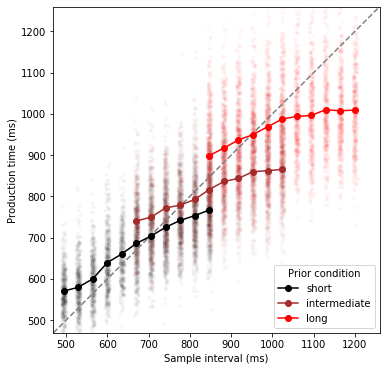

In [27]:
# Remove training trials
dat = dat[dat['Main'] == True]

# Calculate mean Tp by condition
mean_tp_by_subj = dat.groupby(['Subj', 'Cond', 'Ts'])['Tp'].mean().reset_index()
mean_tp = mean_tp_by_subj.groupby(['Cond', 'Ts'])['Tp'].mean().reset_index()

yrange = np.multiply((min(mean_tp['Ts']), max(mean_tp['Ts'])), [0.95, 1.05])

# Subset data for plotting

cond1 = mean_tp.loc[mean_tp['Cond'] == 1]
cond2 = mean_tp.loc[mean_tp['Cond'] == 2]
cond3 = mean_tp.loc[mean_tp['Cond'] == 3]

# Add jitter noise
jitter = dat.copy()
jitter['Ts'] = jitter['Ts'] + np.random.uniform(-5, 5, len(dat))
cond1_jitter = jitter.loc[jitter['Cond'] == 1]
cond2_jitter = jitter.loc[jitter['Cond'] == 2]
cond3_jitter = jitter.loc[jitter['Cond'] == 3]

# Make plot
f, ax = plt.subplots(figsize = (6,6))

ax.set(xlim = yrange, ylim = yrange)
f.gca().set_aspect('equal', adjustable = 'box')

ax.set_xlabel('Sample interval (ms)')
ax.set_ylabel('Production time (ms)')

ax.plot(yrange, yrange, linestyle = '--', color ='gray')

ax.scatter(cond1_jitter['Ts'], cond1_jitter['Tp'], marker = '.', color = 'black', alpha = 0.025, label = None)
ax.scatter(cond2_jitter['Ts'], cond2_jitter['Tp'], marker = '.', color = 'brown', alpha = 0.025, label = None)
ax.scatter(cond3_jitter['Ts'], cond3_jitter['Tp'], marker = '.', color = 'red', alpha = 0.025, label = None)

ax.plot(cond1['Ts'], cond1['Tp'], color = 'black', marker = 'o', label = "short")
ax.plot(cond2['Ts'], cond2['Tp'], color = 'brown', marker = 'o', label = "intermediate")
ax.plot(cond3['Ts'], cond3['Tp'], color = 'red', marker = 'o', label = "long")

ax.legend(title = 'Prior condition', loc = 4)

In [28]:
modelled_data.to_csv("modeldata.csv")